In [1]:
!pip install keras-self-attention transformers hazm &> /dev/null

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import re
import os
import ast
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import pickle


from keras.layers import LSTM
from keras.layers import Dense
from tqdm.notebook import tqdm
from ast import literal_eval
from transformers import BertTokenizer
from sklearn.model_selection import StratifiedKFold
from keras.utils.np_utils import to_categorical

# Config

In [4]:
DATA_PATH = '/content/drive/MyDrive/nlp_proj_data'

# Reading data

In [5]:
all_news = pd.read_csv(os.path.join(DATA_PATH, '/content/drive/MyDrive/nlp_proj_data/news_mean_9_9.csv'), index_col=None)
namads  = list(all_news["nemad"])
news  = list(all_news["news"])
ids = list(all_news["id"])
price_changes = list(all_news['mean_changes'])
prices_str = all_news["prices before"]
prices = [ast.literal_eval(p) for p in prices_str]

number of all news:  8103
max length of news:  811
min length of news:  1
mean length of news:  47.66481550043194


(0.0, 5270.0)

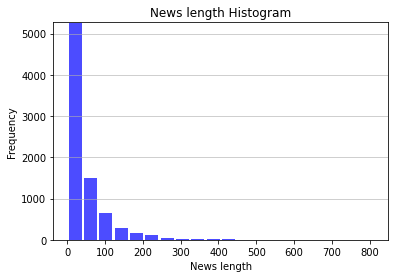

In [6]:
print("number of all news: ", len(news))
news_length = [len(n.split(" ")) for n in news]
print("max length of news: ", max(news_length))
print("min length of news: ", min(news_length))
print("mean length of news: ", np.mean(news_length))

n, bins, patches = plt.hist(x=news_length, bins=20, color='BLUE',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('News length')
plt.ylabel('Frequency')
plt.title('News length Histogram')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


# Preprocess Data

## Label

In [7]:
def calculate_label(score, threshold=450):
  if score < 0: return 0
  return 1

all_news['manual_label'] = all_news.apply(lambda row: calculate_label(row['mean_changes']), axis=1)
labels  = list(all_news["manual_label"])

Text(0.5, 1.0, 'Label Distribution (0: 3470, 1: 4633)')

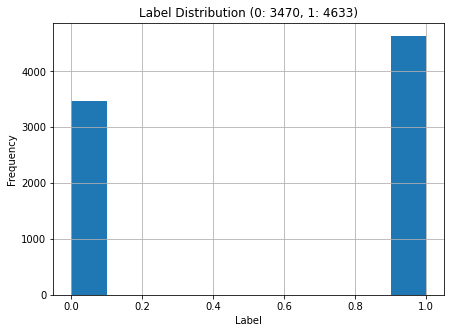

In [8]:
ax = all_news.manual_label.hist(figsize=(7, 5))
ax.set_xlabel("Label")
ax.set_ylabel("Frequency")
ax.set_title('Label Distribution (0: {}, 1: {})'.format(labels.count(0), labels.count(1)))

## Price

In [9]:
def change_price_seq(price_seq):
  last_price = 0
  change_seq = []
  for price in price_seq:
    if price == 0:
      change_seq.append(0)
    else:
      if last_price != 0:
        change_seq.append(price - last_price)
        last_price = price
      else:
        change_seq.append(0)
        last_price = price
  
  return change_seq

change_price_seq(prices[1])

all_news['price_before_changes_seq'] = all_news.apply(
    lambda row: change_price_seq(ast.literal_eval(row['prices before'])), axis=1)
change_seq = all_news['price_before_changes_seq']


## Load BERT embedding

In [10]:
def load_object(name , directory):
    with open(os.path.join(directory, name + '.pkl'), 'rb') as f:
        return pickle.load(f)
        
def load_aggregate_embeddings(name, length, steps=500, offset=500):
  embedding_news = load_object(name='embedding/{}'.format(name), directory=DATA_PATH)
  for i in tqdm(range(0, length + offset, steps)):
    step_emb = load_object(name='embedding/{}_{}'.format(name, i), directory=DATA_PATH)
    embedding_news.update(step_emb)
  return embedding_news

# name= 'embedding_news_namad_only' or 'embedding_news'
embedding_news_bert = load_aggregate_embeddings(name='embedding_news', 
                                           length=len(ids))
len(embedding_news_bert)

  0%|          | 0/18 [00:00<?, ?it/s]

8571

In [11]:
def pad_per_day_news(ids, labels, embedding_news, per_day_news=1, 
                     max_length=250, embedding_length=768):
  all_day_news = []
  cat_labels = []
  for news_id, label in tqdm(zip(ids, labels), total=len(ids)):
    if not news_id in embedding_news.keys(): continue
    day_news = []
    if len(embedding_news[news_id]) <= max_length:
      day_news.append(embedding_news[news_id])
    if len(day_news) == 0: continue
    all_day_news.append(day_news)
    cat_labels.append([label])
  return np.array(all_day_news), np.array(cat_labels)

all_day_news_bert, day_news_labels_bert = pad_per_day_news(ids, labels, embedding_news_bert)
np.shape(all_day_news_bert), np.shape(day_news_labels_bert)

  0%|          | 0/8103 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


((7751, 1), (7751, 1))

## Load fasttext embedding

In [12]:
def map_word_to_number(news_list, fasttext_embedding_filename, pretrained_model):
  tokenizer = BertTokenizer.from_pretrained(pretrained_model)
  fasttext_embedding = load_object(fasttext_embedding_filename, directory=DATA_PATH)

  word_number = {}
  embedding_matrix = []
  word_to_number_list = []
  
  for n, word in enumerate(fasttext_embedding):
    word_number[word] = n+1
    embedding_matrix.append(fasttext_embedding[word])
  
  for news in tqdm(news_list):
    news_number = []
    words_list = tokenizer.tokenize(news)
    for word in words_list:
      try:
        news_number.append(word_number[word])
      except:
        news_number.append(-1)
    word_to_number_list.append([news_number])
  
  return np.array(word_to_number_list), np.array(embedding_matrix)


word_to_number_list, embedding_matrix = map_word_to_number(
    news,"embedding_total_300dic", 'HooshvareLab/bert-fa-zwnj-base') 

word_to_number_list.shape, embedding_matrix.shape

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/292 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/565 [00:00<?, ?B/s]

  0%|          | 0/8103 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


((8103, 1), (8682, 300))

## Model options

In [13]:
# model options

num_classes = 2
embedding_mode = "bert" # the other option is "fasttext"
model_mode = 1  # 1 for with price 0 for without price

# X, y

In [14]:
def concat_x_and_price(X, change_seq):
  X_price = []
  for x, p in zip(X, change_seq):
    x_l = list(x)
    x_l.append(p)
    X_price.append(x_l)
  return X_price

def create_dataset(word_to_number_list, labels, change_seq, num_classes=2):
  all_day_news = []
  for news, label in zip(word_to_number_list, labels):
    all_day_news.append(news)
  y = to_categorical(labels, num_classes=num_classes)
  X = np.array(concat_x_and_price(all_day_news, change_seq))
  return X, y

if embedding_mode == "fasttext":
  print("Fasttext embedding: ")
  X, y = create_dataset(word_to_number_list, labels, change_seq)
  embedding_length = 300
  print(X.shape, y.shape)

if embedding_mode == "bert":
  print("Bert embedding: ")
  X, y = create_dataset(all_day_news_bert, day_news_labels_bert, change_seq)
  embedding_length = 768
  print(X.shape, y.shape)



Bert embedding: 
(7751, 2) (7751, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [15]:
import keras
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, X, price_seq, embedding_mode = embedding_mode, batch_size= 64,max_length = 250,
                 n_classes=num_classes, embedding_length = embedding_length, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.labels = labels
        self.X = X
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.max_length = max_length
        self.embedding_length = embedding_length
        self.price_seq = price_seq
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X_train, price_train, y_train = self.__data_generation(list_IDs_temp)

        return [X_train, price_train], y_train

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes) 

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        X_train = []
        y_train = []
        price_train = []

        for i, ID in enumerate(list_IDs_temp):
          
          for n in self.X[ID]:
            X_train.append(self.pad_news(n))

          y_train.append(np.array(self.labels[ID]))
          price_train.append(np.array(self.price_seq[ID]))

        y_train = np.array(y_train)
        
        X_train = np.asarray(X_train)
        price_train = np.asarray(price_train)

        return X_train, price_train, y_train

    def pad_news(self, news):
      n = list(news)
      while len(n) < self.max_length:
        if embedding_mode == "bert":
          n.append(np.zeros(self.embedding_length))
        elif embedding_mode == "fasttext":
          n.append(0)
      if len(n) > self.max_length:
          n = n[:self.max_length]
      n = np.asarray(n)
      return n
  

# K-Fold Datasets

In [16]:
kfold = StratifiedKFold(n_splits=5)

# Model

In [17]:
import keras
from keras_self_attention import SeqSelfAttention
from keras import layers, regularizers
import keras.backend as K

max_features = embedding_matrix.shape[0]
LSTM_units = 32
hidden_units = [32, 16]
class_num = num_classes

class MyModel(tf.keras.Model):

  def __init__(self, max_features, embedding_matrix,embedding_length,LSTM_units,hidden_units,class_num, model_mode, embedding_mode):
      super(MyModel, self).__init__()
      self.embedding = layers.Embedding(max_features, embedding_length, weights=[embedding_matrix], trainable = True, mask_zero=True) 
      self.lstm = layers.LSTM(LSTM_units, return_sequences=True,  kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01) )
      self.dropout = layers.Dropout(0.5)
      self.masking = layers.Masking(mask_value=0)
      self.price_dense = layers.Dense(hidden_units[0], activation="sigmoid")
      self.concatination_dense = layers.Dense(hidden_units[1], activation="sigmoid")
      self.classification_dense = layers.Dense(class_num, activation = "softmax" , kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))
      self.batch_norm1 = layers.BatchNormalization()
      self.batch_norm2 = layers.BatchNormalization()
      self.word_attention = SeqSelfAttention(attention_activation='softmax')
      self.news_attention = SeqSelfAttention(attention_activation='softmax')
      self.days_attention = SeqSelfAttention(attention_activation='softmax')
      self.model_mode = model_mode
      self.embedding_mode = embedding_mode
      
      
    
  def call(self, k_days_news_list):
    
    k_days_news_list_np = K.eval(k_days_news_list) 

    ############################################ FIRST PART (Price Layer)
    if self.model_mode == 1:
      price_output = self.price_dense(k_days_news_list[1])
    
    ############################################ SECOND PART (News Attention)
    k = 1
    day_news_count = 1
    
    # masked_input = self.masking(k_days_news_list)
    if self.embedding_mode == "fasttext":
      embedding = self.embedding(k_days_news_list[0])
      seq_word_embedding = self.lstm(embedding)
    elif self.embedding_mode == "bert":
      # print("here")
      seq_word_embedding = self.lstm(k_days_news_list[0])

    seq_word_embedding = self.batch_norm1(seq_word_embedding)
    seq_word_embedding = self.dropout(seq_word_embedding)
    news_embedding = self.word_attention(seq_word_embedding)
    news_embedding_sum = K.mean(news_embedding, axis =1)
    news_embedding_sum_np = K.eval(news_embedding_sum)
    news_embedding_sum_reshaped = K.reshape(news_embedding_sum, (-1, day_news_count, news_embedding_sum_np.shape[-1]))
   
    days_embedding = self.news_attention(news_embedding_sum_reshaped)
    days_embedding_sum = K.mean(days_embedding, axis =1)
    days_embedding_sum_np = K.eval(days_embedding_sum)
    
    days_embedding_sum = K.reshape(days_embedding_sum, (-1,days_embedding_sum_np.shape[1]))
 
    ############################################ CONCATINATION
    if self.model_mode == 1:
      concat_outputs = layers.Concatenate()([days_embedding_sum, price_output])
      dense_con = self.concatination_dense(concat_outputs)

    ############################################ OUTPUT
    if self.model_mode == 1:
      out_put = self.classification_dense(dense_con)
    elif self.model_mode == 0:
      out_put = self.classification_dense(days_embedding_sum)


    return out_put




In [ ]:
from sklearn.metrics import classification_report

summaries = []

if model_mode == 1:
  print("Model mode: 1 It uses BEFORE PRICE and NEWS as an input")
elif model_mode == 0:
  print("Model mode:  It only uses NEWS")

if embedding_mode == "bert":
  print("BERT embedding is used")

if embedding_mode == "fasttext":
  print("Fasttext embedding is used")

for train_ids, test_ids in kfold.split(X, y.argmax(1)):
  X_train = X[train_ids]
  y_train = y[train_ids]

  X_test = X[test_ids]
  y_test = y[test_ids]

  train_emb = [[x[0]] for x in X_train]
  train_price = [x[1] for x in X_train]

  test_emb = [[x[0]] for x in X_test]
  test_price = [x[1] for x in X_test]

  id_train = [i for i in range(len(train_emb))]
  training_generator = DataGenerator(id_train, y_train, train_emb, train_price)

  id_test = [i for i in range(len(test_emb))]
  test_generator = DataGenerator(id_test, y_test, test_emb, test_price, batch_size=1, shuffle=False)

  opt = tf.keras.optimizers.RMSprop(learning_rate=0.0005)
  model = MyModel(max_features, embedding_matrix ,embedding_length,LSTM_units,hidden_units,class_num, model_mode,embedding_mode)
  model.compile(loss = "binary_crossentropy", metrics=["accuracy"],optimizer = opt,run_eagerly=True)

  summary = model.fit(training_generator, batch_size=64, epochs=15, verbose=1)
  
  # scores = model.evaluate(test_generator, verbose=1)
  Y_test = np.argmax(test_generator.labels, axis=1)
  y_pred = np.argmax(model.predict(test_generator), axis=1) 
  print(classification_report(Y_test, y_pred))
  # print("{}: {}".format(model.metrics_names[1], scores[1]*100))
  
  # model.save_weights(os.path.join(DATA_PATH, "model{}".format(len(summaries))))
  # summaries.append({'scores': scores, 'summary':summary})

Model mode: 1 It uses BEFORE PRICE and NEWS as an input
BERT embedding is used
Epoch 1/15
96/96 [==============================] - 27s 284ms/step - loss: 2.0724 - accuracy: 0.5636
Epoch 2/15
96/96 [==============================] - 27s 282ms/step - loss: 1.1239 - accuracy: 0.5851
Epoch 3/15
96/96 [==============================] - 28s 289ms/step - loss: 0.9830 - accuracy: 0.5850
Epoch 4/15
96/96 [==============================] - 27s 285ms/step - loss: 0.9291 - accuracy: 0.5978
Epoch 5/15
96/96 [==============================] - 27s 283ms/step - loss: 0.8930 - accuracy: 0.5986
Epoch 6/15
96/96 [==============================] - 27s 280ms/step - loss: 0.8638 - accuracy: 0.5977
Epoch 7/15
96/96 [==============================] - 28s 286ms/step - loss: 0.8398 - accuracy: 0.5975
Epoch 8/15
19/96 [====>.........................] - ETA: 21s - loss: 0.8205 - accuracy: 0.6102

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

Y_test = np.argmax(test_generator.labels, axis=1)
y_pred = np.argmax(model.predict(test_generator), axis=1) 
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.58      0.59       345
           1       0.70      0.72      0.71       466

    accuracy                           0.66       811
   macro avg       0.65      0.65      0.65       811
weighted avg       0.66      0.66      0.66       811

